## Feature Selection

Uses a variety of methods to test the importance of each feature in classification.

### Files Needed:
1. Positions features as a csv

### Instructions:
Run cells in order

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn import metrics

import matplotlib.pyplot as plt
import random as random
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss
import sklearn.linear_model
from sklearn import svm
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score

from sklearn import linear_model #TODO: more models
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import sparse

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.metrics import roc_curve
from sklearn.preprocessing import scale

import statsmodels.api as sm

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

//anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading the input dataset

In [3]:
curr_dir = !pwd
input_path = curr_dir[0]+"/../9.Features_exploration/binding_df/10/"
filename = "positions_features_01.25.18.csv"
bind_scores_num = 10

features_all = pd.read_csv(input_path+filename, sep='\t', index_col=0)
features_cols = features_all.columns[1:-bind_scores_num] #removing binding scores and domain name
ligands = ["dna", "dnabase", "dnabackbone", "rna", "rnabase", "rnabackbone", "peptide", "ion", "metabolite"]

classifiers = {}
classifiers["Logistic"] = LogisticRegression()
classifiers["RF"] = ensemble.RandomForestRegressor(n_estimators=1000)
classifiers["KNN"] = neighbors.KNeighborsRegressor(n_neighbors=50)
classifiers["Lasso"] = linear_model.Lasso(alpha=0.1)
classifiers["Ridge"] = linear_model.RidgeClassifier()
classifiers["SVM"] = svm.SVC(kernel='rbf', gamma = 0.0001, probability=True)

### Checking input features doesn't have NaNs

In [4]:
for col in features_cols:
    nan_idx = np.where( np.isnan(features_all[col].tolist()) == True)[0]
    if (len(nan_idx) > 0):
        print col+" has NaNs"

### Checking input features doesn't have Infs

In [5]:
for col in features_cols:
    inf_idx = np.where(np.isinf(features_all[col].tolist()) == True)[0]
    if (len(inf_idx) > 0):
        print col+" has Inf"

### Datasets of negative examples

In [6]:
non_binding_positions = features_all[features_all["max_binding_score"] == 0]
non_binding_positions = non_binding_positions.loc[:,features_cols]
print "non_binding #: "+str(non_binding_positions.shape[0])

non_binding #: 37359


In [8]:
with open(curr_dir[0]+"/ligands_negatives_domains_dict.pik", 'rb') as handle:
    negatives_dict = pickle.load(handle)

ligands_negatives_df = {}
for ligand in ligands:
    ligands_negatives_df[ligand] = pd.DataFrame()
    for domain in negatives_dict[ligand]:
        if domain == 'negatives' or domain == 'domains':
            continue
        domain_all = features_all.loc[features_all.loc[:,"domain_name"] == domain,:]
        if len(domain_all) == 0:
            continue
        ligands_negatives_df[ligand] = pd.concat([ligands_negatives_df[ligand],domain_all.loc[domain_all.loc[:,"max_binding_score"] == 0,:]])
    
    ligands_negatives_df[ligand] = ligands_negatives_df[ligand][features_cols]
    print(ligand+" non-binding #: "+str(len(ligands_negatives_df[ligand])))

dna non-binding #: 2554
dnabase non-binding #: 1827
dnabackbone non-binding #: 2397
rna non-binding #: 2084
rnabase non-binding #: 2050
rnabackbone non-binding #: 2072
peptide non-binding #: 11223
ion non-binding #: 28670
metabolite non-binding #: 21146


### Datasets of positive examples by ligand

In [9]:
bind_th = 0.1
ligands_features_df = {}

for ligand in ligands:
    score_col_str = ligand+"_binding_score"
    ligand_binding_df = features_all[features_all[score_col_str] >= bind_th]
    ligands_features_df[ligand] = ligand_binding_df.loc[:,features_cols]

### Sampling functions

In [10]:
def sample(iterator, k):
    """
    Samples k elements from an iterable object.

    :param iterator: an object that is iterable
    :param k: the number of items to sample
    """
    # fill the reservoir to start
    result = [next(iterator) for _ in range(k)]

    n = k - 1
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item

    return result

In [11]:
# Down-sample a balanced set with largest possible number of positives
def get_sample(ligand_bind_features,non_binding_positions):
    negative_idx = range(0,len(non_binding_positions))
    sampled_negative_idx = sample(iter(negative_idx), len(ligand_bind_features))
    X = pd.concat([ligand_bind_features, non_binding_positions.iloc[sampled_negative_idx]])

    y = [1] * ligand_bind_features.shape[0]
    y.extend([0] * ligand_bind_features.shape[0])
    y = np.array(y)
    return [X,y]

### Test features and create ranking

In [13]:
# List of features
features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Rankings by ligand/test
ranking = defaultdict(list)

for ligand in ligands:
    # Down-sample
    X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
    
    # Feature selection models
    var_model = VarianceThreshold(threshold=(.3)).fit(X)
    kbest_model = SelectKBest(k=200).fit(X,y)
    trees_model = ExtraTreesClassifier().fit(X,y)

    # Extract feature scores and remove NaNs
    # Variances for var; ANOVA f-value for kbest; Relative importances for trees
    var = np.asarray(var_model.variances_)
    var[np.isnan(var)] = -1
    kbest = np.asarray(kbest_model.scores_)
    kbest[np.isnan(kbest)] = -1
    trees = np.asarray(trees_model.feature_importances_)
    trees[np.isnan(trees)] = -1

    # Create ranking
    ranking[ligand+"_var"] = features_list[np.argsort(var)][::-1]
    ranking[ligand+"_kbest"] = features_list[np.argsort(kbest)][::-1]
    ranking[ligand+"_trees"] = features_list[np.argsort(trees)][::-1]

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [186 207 346 347 348 349] are constant.
  UserWarning)


### Plot top 10 features ranked by RF for two classes of negatives (max binding score is 0)

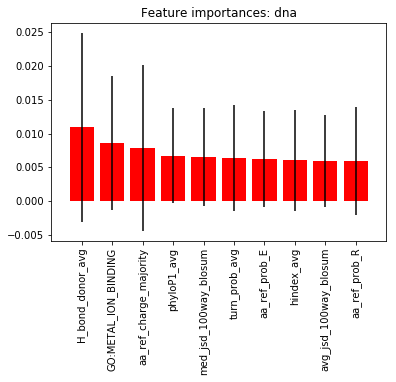

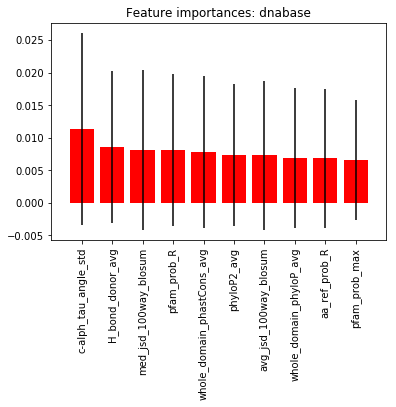

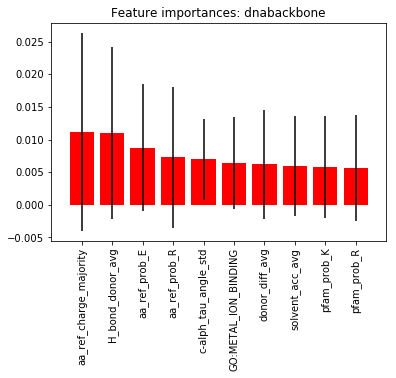

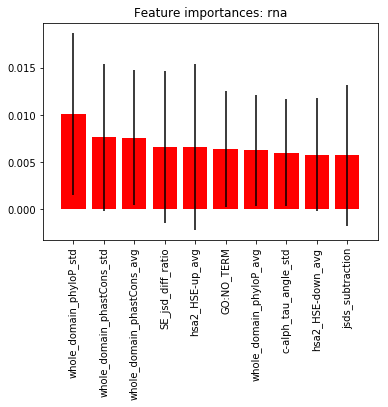

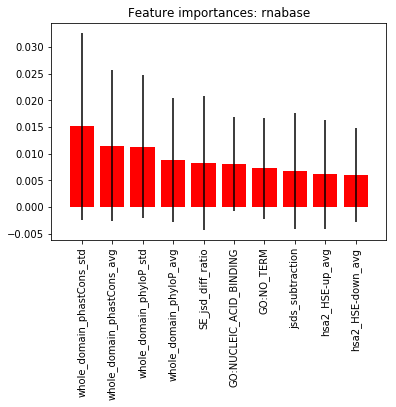

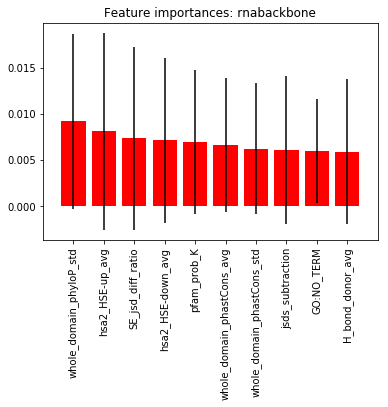

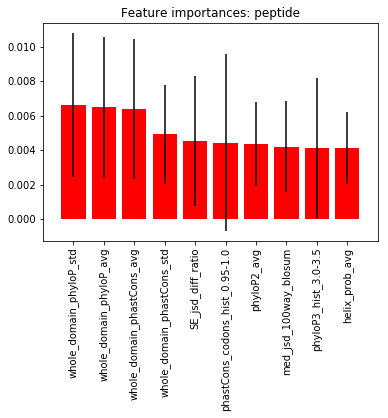

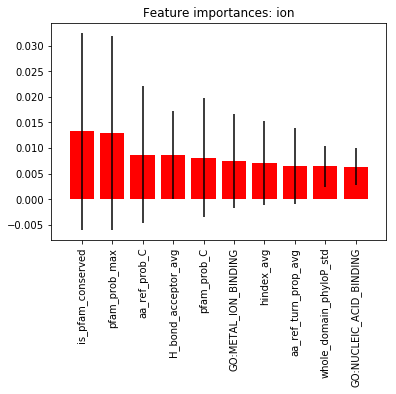

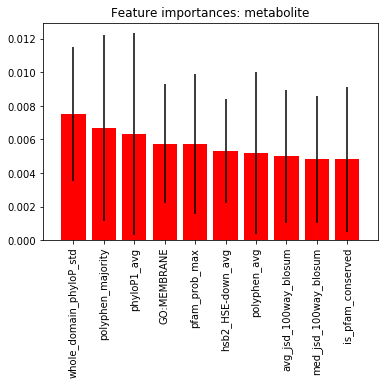

In [15]:
## Ligand negatives only from domains with at least one ligand binding position

features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
for ligand in ligands:
    X,y = get_sample(ligands_features_df[ligand],ligands_negatives_df[ligand])
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(10), importances[indices][0:10],
           color="r", yerr=std[indices][0:10], align="center")
    plt.xticks(range(10), features_list[indices][0:10], rotation=90)
    plt.xlim([-1, 10])
    plt.show()

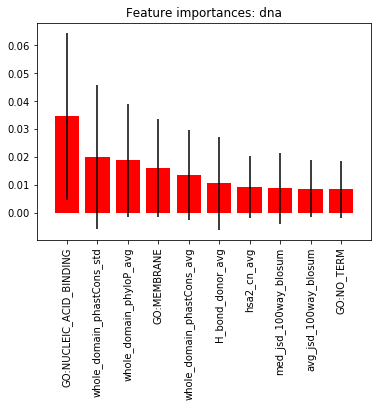

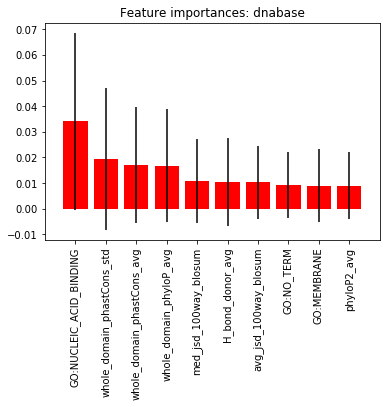

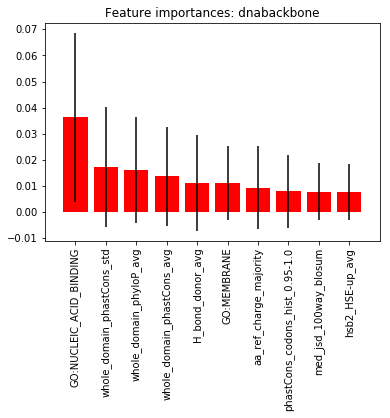

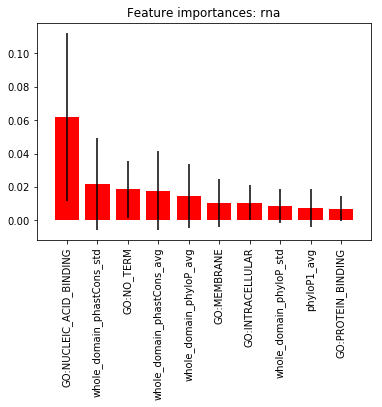

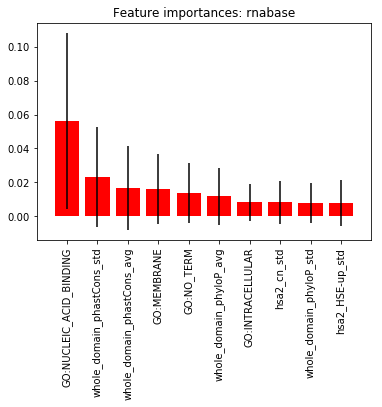

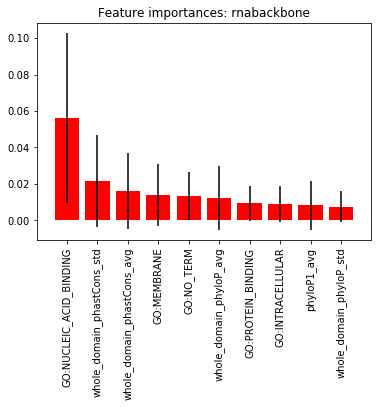

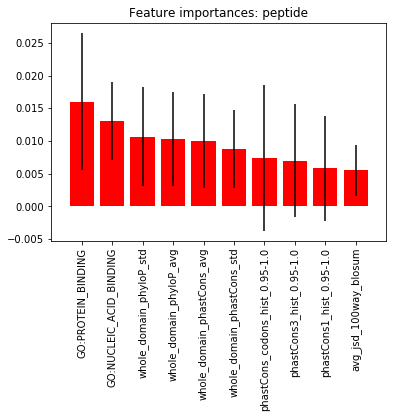

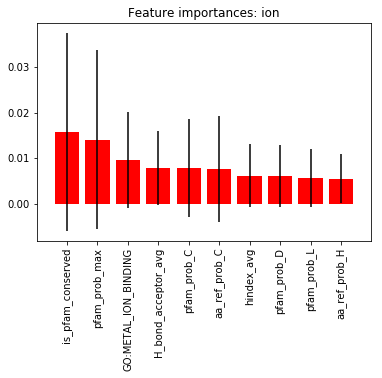

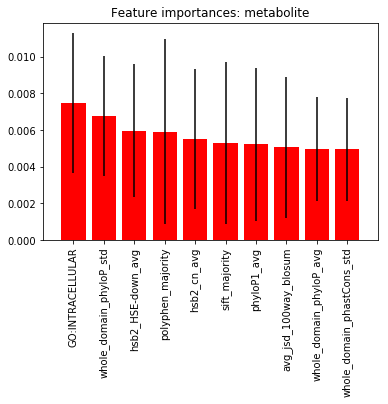

In [16]:
## Negatives from all domains

features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
for ligand in ligands:
    X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
    forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(10), importances[indices][0:10],
           color="r", yerr=std[indices][0:10], align="center")
    plt.xticks(range(10), features_list[indices][0:10], rotation=90)
    plt.xlim([-1, 10])
    plt.show()

### Classifier for a particular ligand-binding
#### Test different algorithms with features removed

In [7]:
def test_model(pred_dict, auc_dict, auprc_dict, ligand_bind_features, ligand_name, features=[]):
    # Default: Exclude no features
    if len(features) == 0:
        features = np.ones([ligand_bind_features.shape[1],]).astype(bool)
        
    #Arranging the features table by the CV order, for each model
    features_pred_dfs = dict.fromkeys(classifiers.keys())
    
    models_req_scaling = ["SVM", "KNN"]
    
    for classifier in classifiers.keys():
        
        model = classifiers[classifier]
        features_pred_dfs[classifier] = pd.DataFrame()
        
        #Create X and y with included features
        X = pd.concat([ligand_bind_features.iloc[:,features], non_binding_positions.iloc[:,features]])
        #X = pd.concat([ligand_bind_features, non_binding_positions])
        X_copy = pd.DataFrame.copy(X)
        
        if (classifier in models_req_scaling):
            idx = X.index
            cols = X.columns
            X = pd.DataFrame(scale(X)) #Is z-scoring the data needed?
            X.index = idx #Restoring indices after scaling
            X.columns = cols

        y = [1] * ligand_bind_features.shape[0]
        y.extend([0] * non_binding_positions.shape[0])
        y = np.array(y)

        binding_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
        pred_idx = 1

        for train_index, test_index in binding_skf.split(X, y):
            X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
            y_train, y_test = y[train_index], y[test_index]

            #Down-sample negative examples to have balanced classes
            negative_idx = np.where(y_train == 0)[0].tolist()
            positive_idx = np.where(y_train == 1)[0].tolist()
            sampled_negative_idx = sample(iter(negative_idx), len(positive_idx))
            X_train_sampled = pd.concat([X_train.iloc[positive_idx], X_train.iloc[sampled_negative_idx]])
            y_train_sampled = np.append(y_train[positive_idx], [0] * len(positive_idx))
            
            #fit to training data
            model = classifiers[classifier]
            model.fit(X_train_sampled, y_train_sampled)
            probs_list = []

            if (classifier == "Logistic" or classifier == "SVM"):
                probs = model.predict_proba(X_test)
                for l in probs:
                    probs_list.append(l[1])
            elif (classifier == "Ridge"):
                probs = model.decision_function(X_test)
                probs_list = probs
            else:
                probs = model.predict(X_test)
                probs_list = probs

            pred_dict["obs"].extend(y_test)
            pred_dict["prob"].extend(probs_list)
            fold_list = [pred_idx] * len(probs_list)
            pred_dict["fold"].extend(fold_list)

            model_list = [classifier] * len(probs_list)
            pred_dict["model"].extend(model_list)

            if (classifier == "Logistic" or classifier == "SVM"):
                #print "auc= "+str(metrics.roc_auc_score(y_test, probs[:, 1]))
                auc_dict[classifier].append(metrics.roc_auc_score(y_test, probs[:, 1]))
                precision, recall, _ = precision_recall_curve(y_test, probs[:, 1])
                
            else:
                #print "auc= "+str(metrics.roc_auc_score(y_test, probs))
                auc_dict[classifier].append(metrics.roc_auc_score(y_test, probs))
                precision, recall, _ = precision_recall_curve(y_test, probs)
            auprc_dict[classifier].append(auc(recall, precision))
            
            #Update features table
            features_pred_dfs[classifier] = features_pred_dfs[classifier].append(X_copy.iloc[test_index,:])
            pred_idx += 1

        avg_auc = np.sum(auc_dict[classifier])/10.0
        print "avg auc = "+str(avg_auc)
        
        avg_auprc = np.sum(auprc_dict[classifier])/10.0
        print "avg auprc = "+str(avg_auprc)
            
        print "Finished "+ligand+" "+classifier
    
    return features_pred_dfs

In [24]:
def combine_features_predictions(ligand, ordered_features, pred_df):
    
    pred_res = pred_df.copy(deep=True)
    for classifier in classifiers.keys():
        
        model_pred = pred_res[pred_res["model"] == classifier]
        model_pred.index = ordered_features[classifier].index
        
        #Creating the combined table
        features_pred = pd.concat([ordered_features[classifier], model_pred], axis=1)
        
        #Saving
        features_pred.to_csv(curr_dir[0]+"/feature_select_df/feature_pred/"+ligand+"_"+classifier+"_features_pred_whole_go.csv", sep='\t')

In [13]:
# Models with features removed
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import ExtraTreesClassifier

kbest_list = [200]
trees_list = [0]

for k_thresh in kbest_list:
    for t_thresh in trees_list:
        for ligand in ligands:
            #Initialize dictionary
            pred_dict = defaultdict(list)
            auc_dict = defaultdict(list)
            auprc_dict = defaultdict(list)

            # Remove features
            X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
            
            # Remove 0 variance features first
            var_model = VarianceThreshold(threshold=0).fit(X)
            var_included = var_model.get_support()
            
            # Kbest
            kbest_model = SelectKBest(k=k_thresh).fit(X,y)
            kbest_included = kbest_model.get_support()

            # Trees
            trees_model = ExtraTreesClassifier().fit(X,y)
            trees_included = (trees_model.feature_importances_ > t_thresh)
            
            # Combine exclusions
            features_included = (var_included & kbest_included & trees_included)

            # Run classifier
            test_model(pred_dict, auc_dict, auprc_dict, ligands_features_df[ligand], ligand, features_included)

            pred_df = pd.DataFrame.from_dict(pred_dict)
            auc_df = pd.DataFrame.from_dict(auc_dict)

            #Save to file
            pred_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_0.1_kbest100.csv", sep='\t')
            auc_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_0.1_auc_kbest100.csv", sep='\t')

            print "Finished ligand "+ligand

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [344 345] are constant.
  UserWarning)
//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


KeyboardInterrupt: 

### Test feature importance by isolating groups of features

In [8]:
## Create groups of features

group_names = ['population','conservation_genome','sub_matrix','selection','conservation_domain','sub_predictor',
               'chemical_major_allele','chemical_substitution','spider','whole_domain']
group_indices = [range(0,21),range(21,103),range(103,113),range(113,116)+range(149,164),range(116,138),range(138,149),
                 range(164,230),range(230,353),range(353,384),range(384,395)]

features_groups = dict(zip(group_names,group_indices))

In [15]:
## Train/test with each group individually

for ligand in ligands:
    n_features = ligands_features_df[ligand].shape[1]
    for group in features_groups:
        # Include features in the group
        features_included = np.zeros([n_features]).astype(bool)
        features_included[features_groups[group]] = True
        
        #Initialize dictionary
        pred_dict = defaultdict(list)
        auc_dict = defaultdict(list)
        auprc_dict = defaultdict(list)

        # Remove 0 variance features
        X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
        var_model = VarianceThreshold(threshold=0).fit(X)
        features_included = features_included & var_model.get_support()

        # Run classifier
        test_model(pred_dict, auc_dict, auprc_dict, ligands_features_df[ligand], ligand, features_included)

        pred_df = pd.DataFrame.from_dict(pred_dict)
        auc_df = pd.DataFrame.from_dict(auc_dict)
        auprc_df = pd.DataFrame.from_dict(auprc_dict)

        #Save to file
        pred_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_"+group+"_indiv_0.1.csv", sep='\t')
        auc_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_"+group+"_indiv_0.1_auc.csv", sep='\t')
        auprc_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_"+group+"_indiv_0.1_auprc.csv", sep='\t')

avg auc = 0.648370504841
avg auprc = 0.0492424794673
Finished dna KNN
avg auc = 0.61853372591
avg auprc = 0.126590899541
Finished dna SVM
avg auc = 0.625785075406
avg auprc = 0.0432144130668
Finished dna Ridge
avg auc = 0.638589321811
avg auprc = 0.0377770331254
Finished dna RF
avg auc = 0.629860539637
avg auprc = 0.0474099752082
Finished dna Logistic
avg auc = 0.564030443049
avg auprc = 0.0599178289917
Finished dna Lasso
avg auc = 0.692536508284
avg auprc = 0.0608786496104
Finished dna KNN
avg auc = 0.578931819141
avg auprc = 0.0890787845652
Finished dna SVM
avg auc = 0.710863236614
avg auprc = 0.0640442912353
Finished dna Ridge
avg auc = 0.708453082814
avg auprc = 0.0555161893943
Finished dna RF
avg auc = 0.623089272885
avg auprc = 0.0698119130962
Finished dna Logistic
avg auc = 0.635945387895
avg auprc = 0.0651928101666
Finished dna Lasso
avg auc = 0.562816209453
avg auprc = 0.0273949666257
Finished dna KNN
avg auc = 0.469311239557
avg auprc = 0.0730112856261
Finished dna SVM
avg au

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


avg auc = 0.674458658892
avg auprc = 0.0942629375471
Finished dna Lasso
avg auc = 0.715730550111
avg auprc = 0.0868722036062
Finished dna KNN
avg auc = 0.73090161549
avg auprc = 0.0836304165702
Finished dna SVM
avg auc = 0.693036832555
avg auprc = 0.0910927895577
Finished dna Ridge
avg auc = 0.71008668844
avg auprc = 0.0689719113774
Finished dna RF
avg auc = 0.713541975414
avg auprc = 0.104963147165
Finished dna Logistic
avg auc = 0.715185281938
avg auprc = 0.0992981278599
Finished dna Lasso
avg auc = 0.677440741921
avg auprc = 0.044597359317
Finished dna KNN
avg auc = 0.663484880975
avg auprc = 0.0428754200475
Finished dna SVM
avg auc = 0.704302335487
avg auprc = 0.0572383530307
Finished dna Ridge
avg auc = 0.713583407186
avg auprc = 0.0834823854506
Finished dna RF
avg auc = 0.711442806432
avg auprc = 0.0595972746835
Finished dna Logistic
avg auc = 0.699812079655
avg auprc = 0.0655484772952
Finished dna Lasso
avg auc = 0.676415124103
avg auprc = 0.134112007254
Finished dna KNN
avg auc

avg auc = 0.53284050166
avg auprc = 0.0422205526712
Finished dnabackbone Ridge
avg auc = 0.58835175537
avg auprc = 0.0259925431508
Finished dnabackbone RF
avg auc = 0.557519161401
avg auprc = 0.0556851573579
Finished dnabackbone Logistic
avg auc = 0.558232145426
avg auprc = 0.0736025724905
Finished dnabackbone Lasso
avg auc = 0.709729476245
avg auprc = 0.0893138524585
Finished dnabackbone KNN
avg auc = 0.724347588526
avg auprc = 0.0892889526958
Finished dnabackbone SVM
avg auc = 0.713504648262
avg auprc = 0.0778063927997
Finished dnabackbone Ridge
avg auc = 0.749780717154
avg auprc = 0.099715280749
Finished dnabackbone RF
avg auc = 0.716392567345
avg auprc = 0.0972510896741
Finished dnabackbone Logistic
avg auc = 0.675682844695
avg auprc = 0.0864223684235
Finished dnabackbone Lasso
avg auc = 0.72747917499
avg auprc = 0.0753060231518
Finished dnabackbone KNN
avg auc = 0.731593721572
avg auprc = 0.0735772956325
Finished dnabackbone SVM
avg auc = 0.68822515614
avg auprc = 0.0570863618678


avg auc = 0.476849864998
avg auprc = 0.0255205756558
Finished rnabase Lasso
avg auc = 0.692135592682
avg auprc = 0.0340900655439
Finished rnabase KNN
avg auc = 0.59029816594
avg auprc = 0.125354345021
Finished rnabase SVM
avg auc = 0.643770629937
avg auprc = 0.0418444198477
Finished rnabase Ridge
avg auc = 0.679587970824
avg auprc = 0.0220387992882
Finished rnabase RF
avg auc = 0.545437259693
avg auprc = 0.0109512246871
Finished rnabase Logistic
avg auc = 0.618703656464
avg auprc = 0.020622145399
Finished rnabase Lasso
avg auc = 0.541260412784
avg auprc = 0.0309965535822
Finished rnabase KNN
avg auc = 0.471987626885
avg auprc = 0.1328478845
Finished rnabase SVM
avg auc = 0.534946528518
avg auprc = 0.0288770704168
Finished rnabase Ridge
avg auc = 0.587499340557
avg auprc = 0.0151569445821
Finished rnabase RF
avg auc = 0.513411441741
avg auprc = 0.0221074152383
Finished rnabase Logistic
avg auc = 0.494196761109
avg auprc = 0.0421453556462
Finished rnabase Lasso
avg auc = 0.638511309459
a

avg auc = 0.643647214754
avg auprc = 0.0281602478765
Finished rnabackbone Logistic
avg auc = 0.5
avg auprc = 0.506055469476
Finished rnabackbone Lasso
avg auc = 0.608934450241
avg auprc = 0.018106602231
Finished rnabackbone KNN
avg auc = 0.486171600061
avg auprc = 0.0811734288919
Finished rnabackbone SVM
avg auc = 0.517500502507
avg auprc = 0.0224792852336
Finished rnabackbone Ridge
avg auc = 0.626185003773
avg auprc = 0.028282759106
Finished rnabackbone RF
avg auc = 0.526022842384
avg auprc = 0.0249305780379
Finished rnabackbone Logistic
avg auc = 0.466330374652
avg auprc = 0.0510917190461
Finished rnabackbone Lasso
avg auc = 0.581798999914
avg auprc = 0.103818652519
Finished peptide KNN
avg auc = 0.614103937557
avg auprc = 0.139354106713
Finished peptide SVM
avg auc = 0.605630828795
avg auprc = 0.134759785209
Finished peptide Ridge
avg auc = 0.565788675466
avg auprc = 0.0897459003605
Finished peptide RF
avg auc = 0.606201505181
avg auprc = 0.129774162085
Finished peptide Logistic
avg

avg auc = 0.63329672077
avg auprc = 0.108839890129
Finished ion RF
avg auc = 0.623147687086
avg auprc = 0.0885200991143
Finished ion Logistic
avg auc = 0.572089560586
avg auprc = 0.0755775380147
Finished ion Lasso
avg auc = 0.709901981812
avg auprc = 0.211120565776
Finished ion KNN
avg auc = 0.701662899824
avg auprc = 0.219781917006
Finished ion SVM
avg auc = 0.711502866622
avg auprc = 0.22989792787
Finished ion Ridge
avg auc = 0.696043428755
avg auprc = 0.177939959562
Finished ion RF
avg auc = 0.710439837396
avg auprc = 0.226894323608
Finished ion Logistic
avg auc = 0.5
avg auprc = 0.521651725559
Finished ion Lasso
avg auc = 0.552060532954
avg auprc = 0.0783098472521
Finished ion KNN
avg auc = 0.46455991945
avg auprc = 0.232541060595
Finished ion SVM
avg auc = 0.560289090836
avg auprc = 0.0644635171222
Finished ion Ridge
avg auc = 0.524924502989
avg auprc = 0.0507767256663
Finished ion RF
avg auc = 0.571495247301
avg auprc = 0.0700708207315
Finished ion Logistic
avg auc = 0.5443170221

In [9]:
## Train/test with all groups except one

for ligand in ligands:
    n_features = ligands_features_df[ligand].shape[1]
    for group in features_groups:
        # Include features in the group
        features_included = np.ones([n_features]).astype(bool)
        features_included[features_groups[group]] = False
        
        #Initialize dictionary
        pred_dict = defaultdict(list)
        auc_dict = defaultdict(list)
        auprc_dict = defaultdict(list)

        # Remove 0 variance features
        X,y = get_sample(ligands_features_df[ligand],non_binding_positions)
        var_model = VarianceThreshold(threshold=0).fit(X)
        features_included = features_included & var_model.get_support()
        
        # Run classifier
        test_model(pred_dict, auc_dict, auprc_dict, ligands_features_df[ligand], ligand, features_included)

        pred_df = pd.DataFrame.from_dict(pred_dict)
        auc_df = pd.DataFrame.from_dict(auc_dict)
        auprc_df = pd.DataFrame.from_dict(auprc_dict)

        #Save to file
        pred_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_"+group+"_except_0.1.csv", sep='\t')
        auc_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_"+group+"_except_0.1_auc.csv", sep='\t')
        auprc_df.to_csv(curr_dir[0]+"/feature_select_df/"+ligand+"_"+group+"_except_0.1_auprc.csv", sep='\t')

avg auc = 0.814565819735
avg auprc = 0.192756804642
Finished dna KNN
avg auc = 0.835090990348
avg auprc = 0.173970932746
Finished dna SVM
avg auc = 0.859977747516
avg auprc = 0.154337272846
Finished dna Ridge
avg auc = 0.941330202032
avg auprc = 0.406146730726
Finished dna RF
avg auc = 0.729297598791
avg auprc = 0.0901585031407
Finished dna Logistic


//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


avg auc = 0.784781241408
avg auprc = 0.141583628992
Finished dna Lasso
avg auc = 0.820083094653
avg auprc = 0.193837183323
Finished dna KNN
avg auc = 0.838407975866
avg auprc = 0.157872939196
Finished dna SVM
avg auc = 0.864605982702
avg auprc = 0.163841119411
Finished dna Ridge
avg auc = 0.934250171587
avg auprc = 0.371487997821
Finished dna RF
avg auc = 0.859525734223
avg auprc = 0.19680021758
Finished dna Logistic
avg auc = 0.778684943722
avg auprc = 0.136919459879
Finished dna Lasso
avg auc = 0.8181646965
avg auprc = 0.18405811867
Finished dna KNN
avg auc = 0.837682595343
avg auprc = 0.170213238444
Finished dna SVM
avg auc = 0.867171840476
avg auprc = 0.185269724593
Finished dna Ridge
avg auc = 0.942087941964
avg auprc = 0.413116035798
Finished dna RF
avg auc = 0.716291347073
avg auprc = 0.0891231672439
Finished dna Logistic
avg auc = 0.78653073571
avg auprc = 0.13249135799
Finished dna Lasso
avg auc = 0.824913310669
avg auprc = 0.185059470486
Finished dna KNN
avg auc = 0.837167740

avg auc = 0.705959733609
avg auprc = 0.0708302139343
Finished dnabase Logistic
avg auc = 0.778495184546
avg auprc = 0.053161188757
Finished dnabase Lasso
avg auc = 0.816254471634
avg auprc = 0.187867906326
Finished dnabackbone KNN
avg auc = 0.834217925252
avg auprc = 0.144926513588
Finished dnabackbone SVM
avg auc = 0.858209537
avg auprc = 0.133631384955
Finished dnabackbone Ridge
avg auc = 0.927033851005
avg auprc = 0.373971705176
Finished dnabackbone RF
avg auc = 0.720097226831
avg auprc = 0.0788650054876
Finished dnabackbone Logistic
avg auc = 0.795785562675
avg auprc = 0.128680154418
Finished dnabackbone Lasso
avg auc = 0.818201768167
avg auprc = 0.179996723001
Finished dnabackbone KNN
avg auc = 0.837432874736
avg auprc = 0.143956707411
Finished dnabackbone SVM
avg auc = 0.849514692593
avg auprc = 0.1442805967
Finished dnabackbone Ridge
avg auc = 0.932578675856
avg auprc = 0.372675519884
Finished dnabackbone RF
avg auc = 0.846711735377
avg auprc = 0.155360019035
Finished dnabackbon

avg auc = 0.802983954125
avg auprc = 0.0753935427769
Finished rna KNN
avg auc = 0.823366685559
avg auprc = 0.12139163417
Finished rna SVM
avg auc = 0.855660262301
avg auprc = 0.112728662117
Finished rna Ridge
avg auc = 0.955673650519
avg auprc = 0.257876307019
Finished rna RF
avg auc = 0.684649386053
avg auprc = 0.0541553847311
Finished rna Logistic
avg auc = 0.766757878935
avg auprc = 0.0727545046028
Finished rna Lasso
avg auc = 0.814177681296
avg auprc = 0.0854053324825
Finished rna KNN
avg auc = 0.822737563404
avg auprc = 0.10750263476
Finished rna SVM
avg auc = 0.870170571272
avg auprc = 0.115007102291
Finished rna Ridge
avg auc = 0.954270083224
avg auprc = 0.274359466714
Finished rna RF
avg auc = 0.712397986741
avg auprc = 0.0703740355778
Finished rna Logistic
avg auc = 0.770461098251
avg auprc = 0.0743486428181
Finished rna Lasso
avg auc = 0.819479560677
avg auprc = 0.0429912671106
Finished rnabase KNN
avg auc = 0.808706506685
avg auprc = 0.075220204512
Finished rnabase SVM
avg a

avg auc = 0.741127102726
avg auprc = 0.058119767573
Finished rnabackbone SVM
avg auc = 0.766872800699
avg auprc = 0.0467367707786
Finished rnabackbone Ridge
avg auc = 0.887879534124
avg auprc = 0.134435983063
Finished rnabackbone RF
avg auc = 0.681846739525
avg auprc = 0.0338893712045
Finished rnabackbone Logistic
avg auc = 0.74859195798
avg auprc = 0.046381826056
Finished rnabackbone Lasso
avg auc = 0.819088968371
avg auprc = 0.0583998790815
Finished rnabackbone KNN
avg auc = 0.80647548366
avg auprc = 0.0721169543395
Finished rnabackbone SVM
avg auc = 0.866071311095
avg auprc = 0.0845576615714
Finished rnabackbone Ridge
avg auc = 0.943829638515
avg auprc = 0.215583852013
Finished rnabackbone RF
avg auc = 0.674010160754
avg auprc = 0.0326764841701
Finished rnabackbone Logistic
avg auc = 0.764982796728
avg auprc = 0.0489985967079
Finished rnabackbone Lasso
avg auc = 0.782496895207
avg auprc = 0.0536581543231
Finished rnabackbone KNN
avg auc = 0.800934814297
avg auprc = 0.065602466109
Fi

avg auc = 0.695194919591
avg auprc = 0.15951682859
Finished ion Logistic
avg auc = 0.674779516426
avg auprc = 0.122633606488
Finished ion Lasso
avg auc = 0.725321512037
avg auprc = 0.219077341381
Finished ion KNN
avg auc = 0.729117993213
avg auprc = 0.20632088537
Finished ion SVM
avg auc = 0.732686222135
avg auprc = 0.156269588869
Finished ion Ridge
avg auc = 0.770112255508
avg auprc = 0.247205282853
Finished ion RF
avg auc = 0.688883637068
avg auprc = 0.163910735407
Finished ion Logistic
avg auc = 0.665969009242
avg auprc = 0.1254243044
Finished ion Lasso
avg auc = 0.729054212639
avg auprc = 0.212481402655
Finished ion KNN
avg auc = 0.724346154228
avg auprc = 0.200877998866
Finished ion SVM
avg auc = 0.725676472574
avg auprc = 0.156708174536
Finished ion Ridge
avg auc = 0.758901240521
avg auprc = 0.25760308632
Finished ion RF
avg auc = 0.696291025731
avg auprc = 0.160811366837
Finished ion Logistic
avg auc = 0.681135323092
avg auprc = 0.136479599111
Finished ion Lasso
avg auc = 0.7457